In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [4]:
nl = 1
abn = 8
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
normal_data = x_train[y_train == nl]
normal_labels = y_train[y_train == nl]
test_data = x_test[(y_test == abn) | (y_test == nl)]
test_labels = y_test[(y_test == abn) | (y_test == nl)]
test_labels_T_F = np.where(test_labels == nl, True, False)

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
normal_data.shape, test_data.shape, test_labels.shape

((6742, 28, 28), (2109, 28, 28), (2109,))

In [6]:
normal_test_data = test_data[test_labels == nl]
abnormal_test_data = test_data[test_labels == abn]
normal_test_labels = test_labels[test_labels == nl]
abnormal_test_labels = test_labels[test_labels == abn]

In [7]:
normal_test_data.shape, abnormal_test_data.shape   #, normal_test_labels[0:20], abnormal_test_labels[0:20]

((1135, 28, 28), (974, 28, 28))

In [8]:
def show_reconstructions(model, images=test_data, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [9]:
K = keras.backend
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [11]:
codings_size = 16

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")
history = variational_ae.fit(normal_data, normal_data, epochs=100, batch_size=512,
                             validation_data=(test_data, test_data), shuffle=True)

Epoch 1/100
14/14 [==============================] - 12s 59ms/step - loss: 0.3712 - val_loss: 0.2659
Epoch 2/100
14/14 [==============================] - 0s 25ms/step - loss: 0.1513 - val_loss: 0.2443
Epoch 3/100
14/14 [==============================] - 0s 30ms/step - loss: 0.1248 - val_loss: 0.2469
Epoch 4/100
14/14 [==============================] - 0s 27ms/step - loss: 0.1127 - val_loss: 0.2465
Epoch 5/100
14/14 [==============================] - 0s 18ms/step - loss: 0.1064 - val_loss: 0.2136
Epoch 6/100
14/14 [==============================] - 0s 23ms/step - loss: 0.0997 - val_loss: 0.2917
Epoch 7/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0989 - val_loss: 0.3593
Epoch 8/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0967 - val_loss: 0.2501
Epoch 9/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0935 - val_loss: 0.2835
Epoch 10/100
14/14 [==============================] - 0s 23ms/step - loss: 0.0917 - val_loss: 0.281

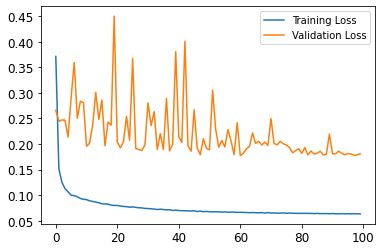

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

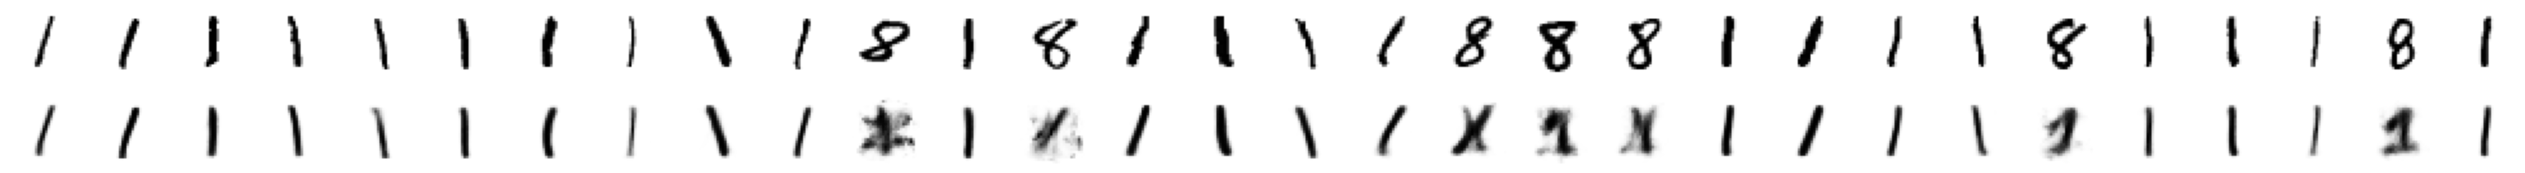

In [13]:
show_reconstructions(variational_ae, test_data, 30)
plt.show()

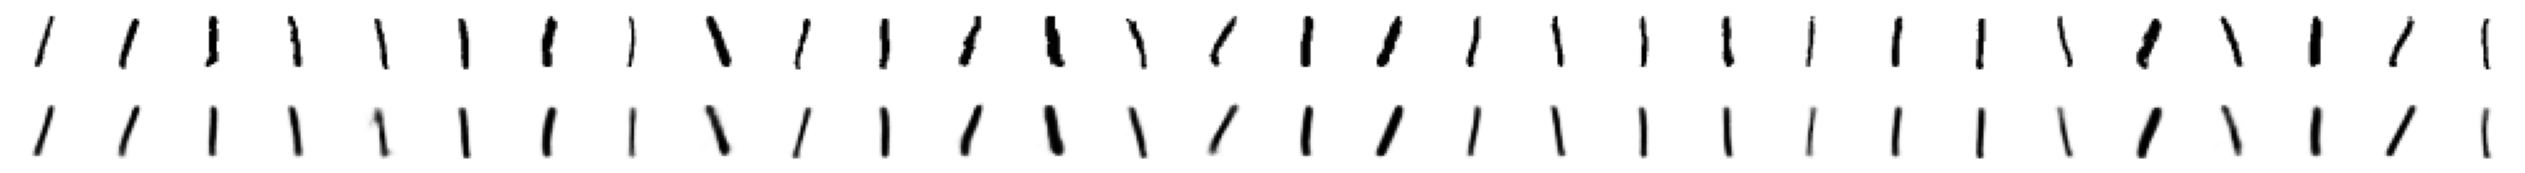

In [14]:
show_reconstructions(variational_ae, normal_test_data, 30)
plt.show()

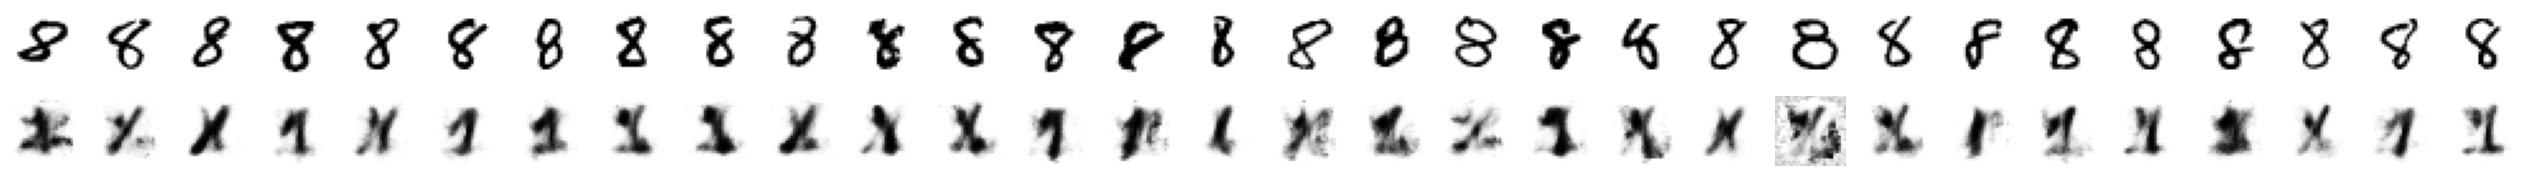

In [15]:
show_reconstructions(variational_ae, abnormal_test_data, 30)
plt.show()

In [16]:
reconstructions_nl_test = variational_ae.predict(normal_test_data)

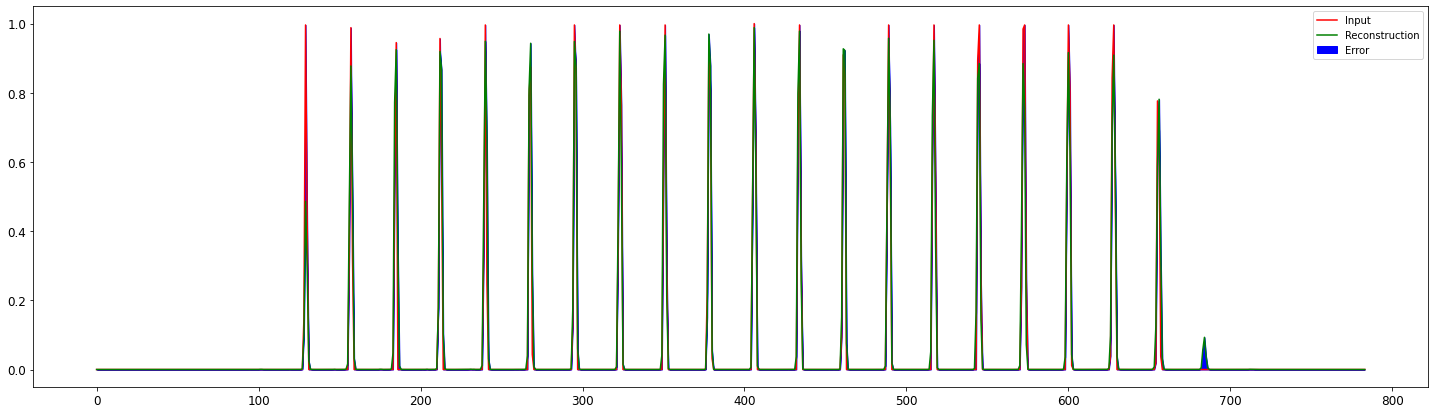

In [17]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_nl_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_nl_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [18]:
reconstructions_abn_test = variational_ae.predict(abnormal_test_data)

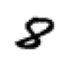

In [19]:
plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

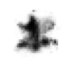

In [20]:
plt.figure(figsize=(1,1))
plt.imshow(reconstructions_abn_test[0], cmap="binary")
plt.axis('off')
plt.show()

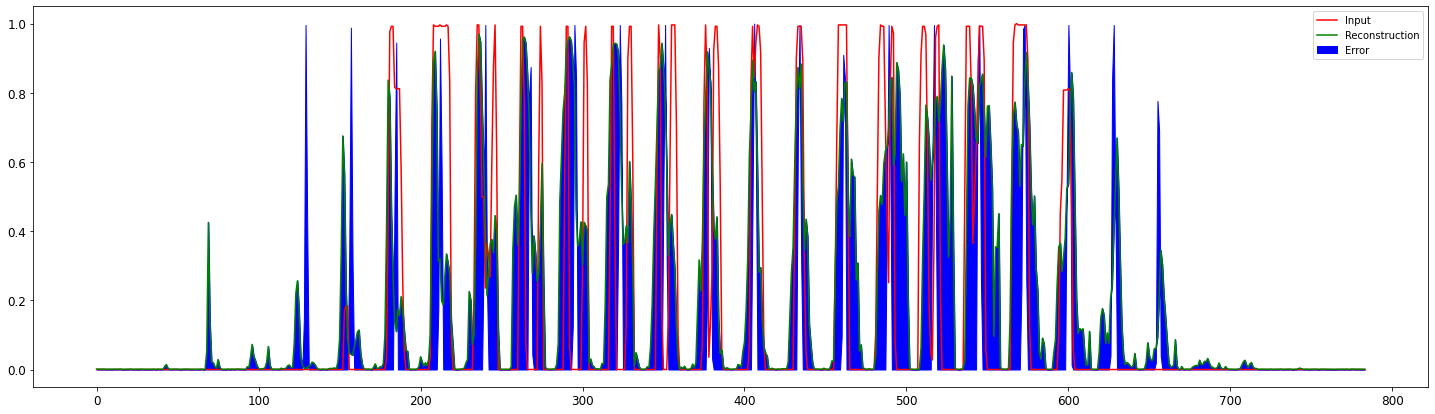

In [21]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(reconstructions_abn_test[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), reconstructions_abn_test[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

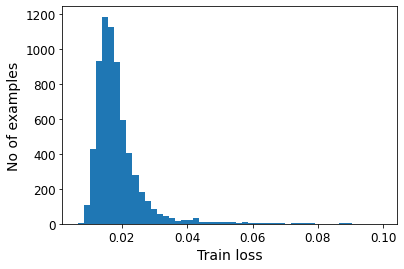

In [22]:
reconstructions_nl_data = variational_ae.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions_nl_data.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [23]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.02703767


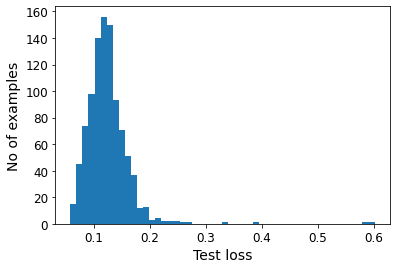

In [24]:
abn_test_loss = tf.keras.losses.mae(reconstructions_abn_test.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [25]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [26]:
preds = predict(variational_ae, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1068   1041
 label: F   [[974   0]    974
        T    [94   1041]]   1135
Accuracy = 0.9554291133238502
Precision = 1.0
Recall = 0.9171806167400881


In [27]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 974    0]
 [  94 1041]]


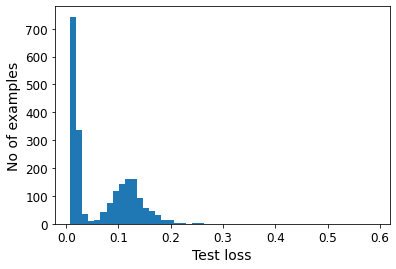

In [28]:
reconstructions_test_data = variational_ae.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions_test_data.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [29]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

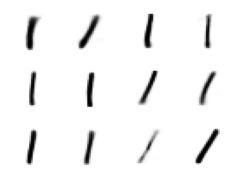

In [30]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
# save_fig("vae_generated_images_plot", tight_layout=False)

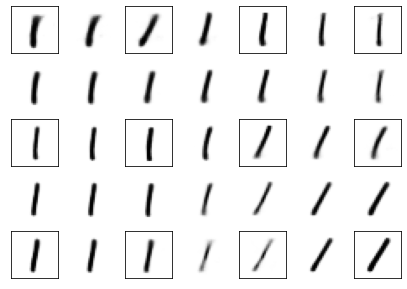

In [31]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
# save_fig("semantic_interpolation_plot", tight_layout=False)